# <center> Sentiment Analysis <center>

This notebook explores sentiment-labeled IMDB movie reviews.  
Our goal is to understand the structure of the data and extract meaningful patterns that can help build a predictive model.

- Problem type: **binary classification**
- Target variable: `sentiment` (positive / negative)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import os
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from gensim.models import Word2Vec

stop_words = set(stopwords.words('english'))
sns.set_theme(style='darkgrid')


## Dataset Overview

Let’s take a look at the basic structure of the dataset:  
- number of samples  
- data types  
- missing values  
- class balance

In [96]:
df = pd.read_csv('../data/IMDB Dataset.csv')
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [97]:
df.shape

(50000, 2)

In [98]:
df.describe()


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Class Distribution

We will check whether the dataset is balanced in terms of the target classes (`positive` vs `negative`).


In [100]:
sentiment_counts = df['sentiment'].value_counts()
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

## Review Length Analysis

We’ll calculate the length of each review:
- in characters
- in words

This helps to understand how much information is contained in each text.

In [101]:
review = df['review']
review.str.len().head(10)

0    1761
1     998
2     926
3     748
4    1317
5     656
6     726
7     934
8     681
9     176
Name: review, dtype: int64

In [102]:
review.str.split().apply(len).head(10)

0    307
1    162
2    166
3    138
4    230
5    119
6    150
7    174
8    130
9     33
Name: review, dtype: int64

---

## Text Preprocessing

Text cleaning steps include:
- Lowercasing
- Removing HTML tags
- Removing punctuation and digits
- Removing stopwords (from NLTK)

This helps reduce noise and improves feature extraction later.


In [103]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return ' '.join(filtered)

In [104]:
df['clean_text'] = df['review'].apply(clean_text)
df['review_length'] = df['clean_text'].apply(lambda x: len(x.split()))
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

## Cleaned Text Length Distribution

After applying text preprocessing (lowercasing, removing HTML/punctuation/stopwords), we examine how the word count per review has changed.

This helps us understand how verbose the reviews are and whether we should apply length thresholds or truncation in later modeling steps.

We observe that the majority of cleaned reviews contain between 100 and 300 words.


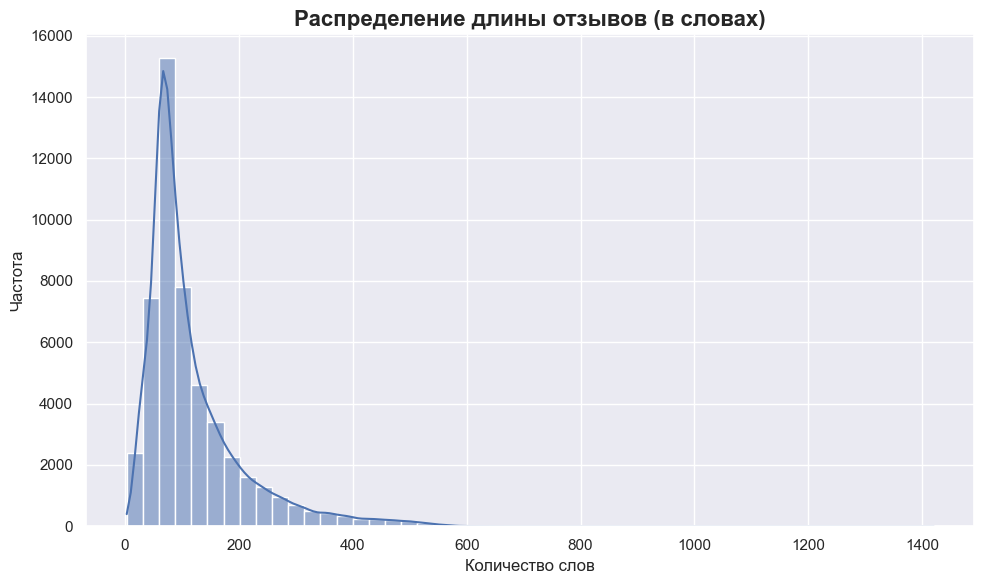

In [105]:
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Распределение длины отзывов (в словах)', fontsize=16, fontweight='bold')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.tight_layout()
plt.savefig('../plots/review_length_distribution.png')


## Top Frequent Words

We will analyze the most common words in each sentiment class:

- ✅ **Positive** reviews
- ❌ **Negative** reviews

This will help us understand word sentiment associations.

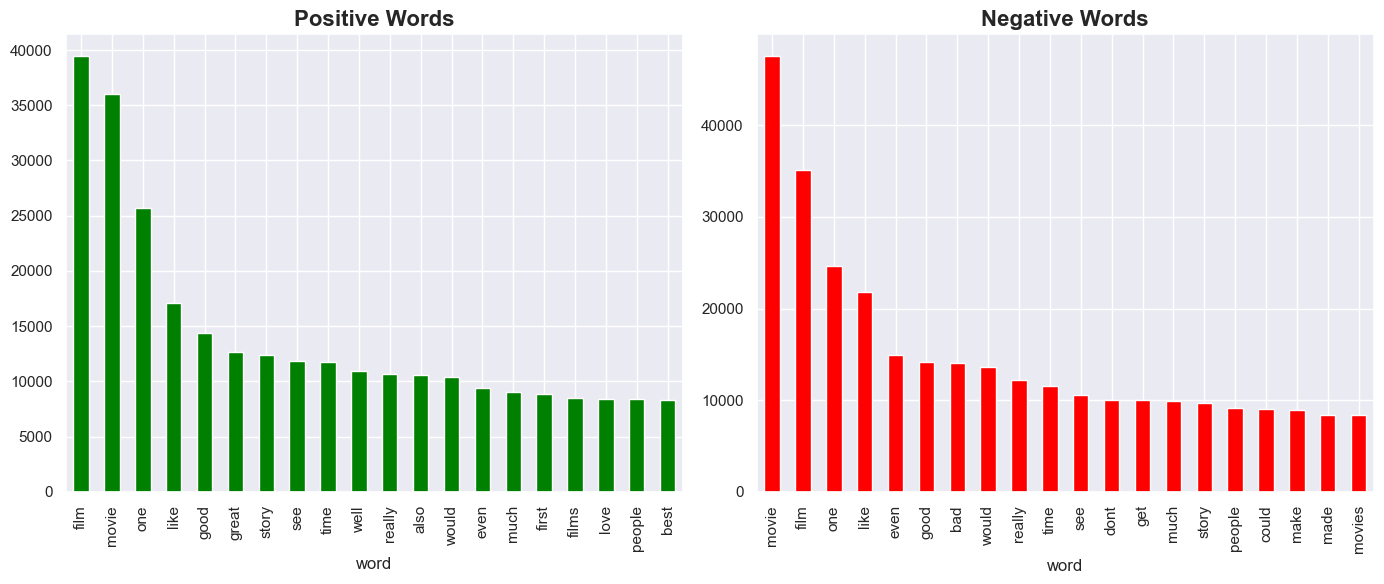

In [ ]:
positive_words = ' '.join(df[df['sentiment'] == 1]['clean_text']).split()
negative_words = ' '.join(df[df['sentiment'] == 0]['clean_text']).split()

# Подсчёт наиболее частых слов
pos_common = Counter(positive_words).most_common(20)
neg_common = Counter(negative_words).most_common(20)

# Создание графиков
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# График для положительных слов
pd.DataFrame(pos_common, columns=['word', 'count']).set_index('word').plot(
    kind='bar', ax=axes[0], legend=False, color='green'
)
axes[0].set_title('Positive Words', fontsize=16, fontweight='bold')

# График для отрицательных слов
pd.DataFrame(neg_common, columns=['word', 'count']).set_index('word').plot(
    kind='bar', ax=axes[1], legend=False, color='red'
)
axes[1].set_title('Negative Words', fontsize=16, fontweight='bold')

# Финальная настройка
plt.tight_layout()
plt.show()

## WordCloud: Positive Sentiment

A visual representation of the most frequent **positive** words.


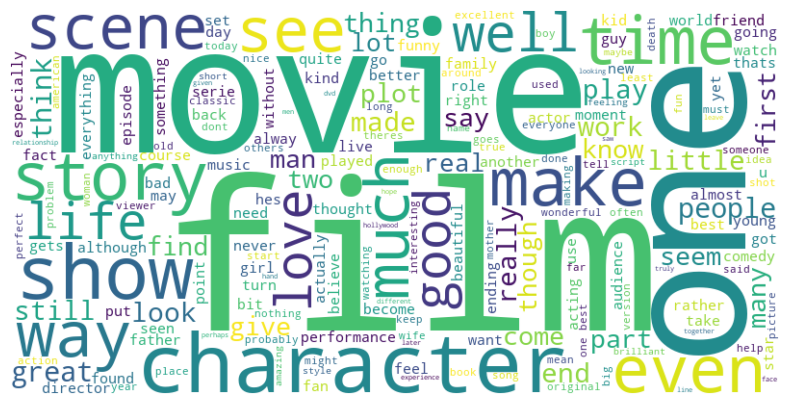

In [107]:
cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
plt.figure(figsize=(10, 5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')

## WordCloud: Positive Bigrams

Here we visualize frequent **2-word combinations (bigrams)** from positive reviews — this reveals common positive expressions.


[(('one', 'best'), 1608), (('ive', 'seen'), 1061), (('even', 'though'), 1016), (('ever', 'seen'), 916), (('first', 'time'), 904), (('dont', 'know'), 862), (('new', 'york'), 802), (('special', 'effects'), 763), (('see', 'movie'), 718), (('years', 'ago'), 703)]


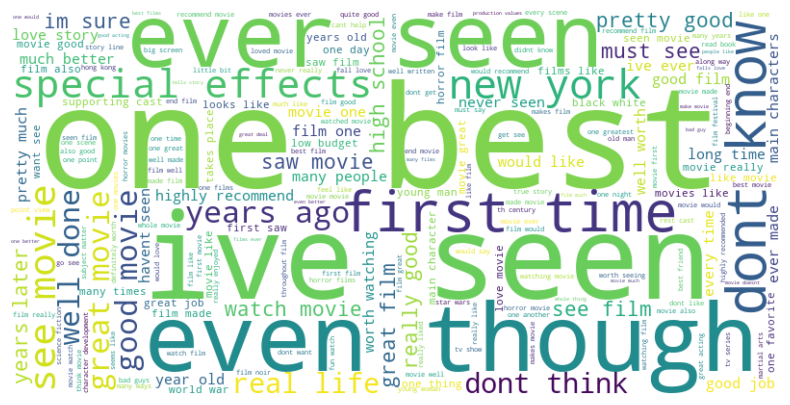

In [108]:
bigrams = list(ngrams(positive_words, 2))
bigram_freq = Counter(bigrams)
print(bigram_freq.most_common(10))

bigram_freq_str = {" ".join(bigram): freq for bigram, freq in bigram_freq.items()}

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(bigram_freq_str)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

[(('ever', 'seen'), 1617), (('special', 'effects'), 1371), (('waste', 'time'), 1355), (('looks', 'like'), 1220), (('dont', 'know'), 1192), (('ive', 'seen'), 1087), (('much', 'better'), 957), (('one', 'worst'), 943), (('look', 'like'), 930), (('even', 'though'), 852)]


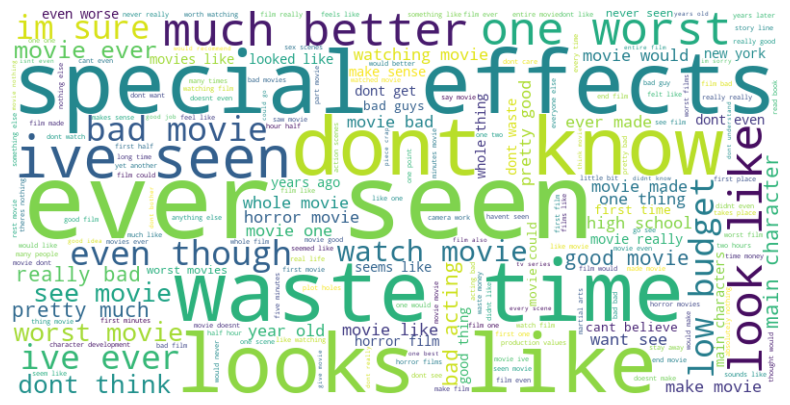

In [109]:
bigrams = list(ngrams(negative_words, 2))
bigram_freq = Counter(bigrams)
print(bigram_freq.most_common(10))

bigram_freq_str = {" ".join(bigram): freq for bigram, freq in bigram_freq.items()}

wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(bigram_freq_str)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Summary

- The dataset is balanced: 50% positive, 50% negative.
- Positive reviews often include words like *"best"*, *"wonderful"*, *"loved"*.
- Negative reviews often contain *"worst"*, *"boring"*, *"waste"*.
- Most reviews are between 100–300 words long.
- Cleaned and tokenized text is now ready for feature engineering (TF-IDF, Word2Vec, etc.)

---

## TF-IDF + LogReg / NaiveBayes

Splitting into training and test samples

In [110]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sentiment'], test_size=0.2, random_state=42)


Text vectorization

In [111]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Models

In [112]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'NaiveBayes': MultinomialNB()
}

Training and visualization of ROC curves


LogisticRegression classification report:

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


NaiveBayes classification report:

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



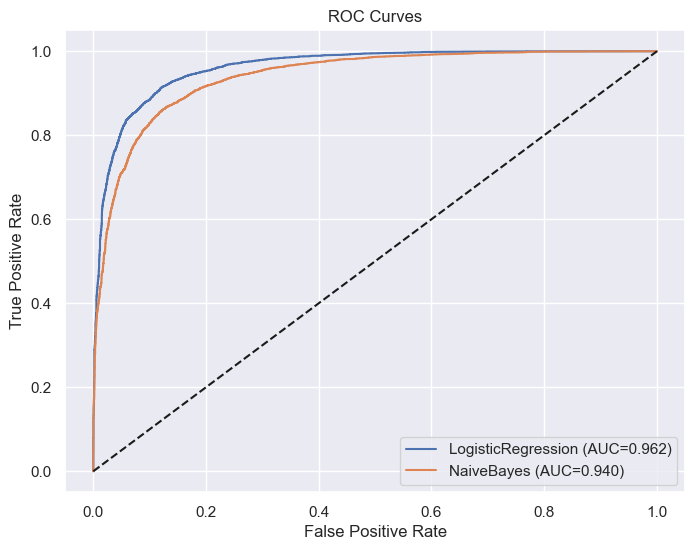

In [117]:
results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    y_prob = model.predict_proba(X_test_vec)[:, 1]

    print(f"\n{name} classification report:\n")
    print(classification_report(y_test, y_pred))

    auc = roc_auc_score(y_test, y_prob)
    acc = model.score(X_test_vec, y_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    results[name] = {
        'acc': acc,
        'auc': auc,
        'cm': confusion_matrix(y_test, y_pred)
    }

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

### Confusion Matrices

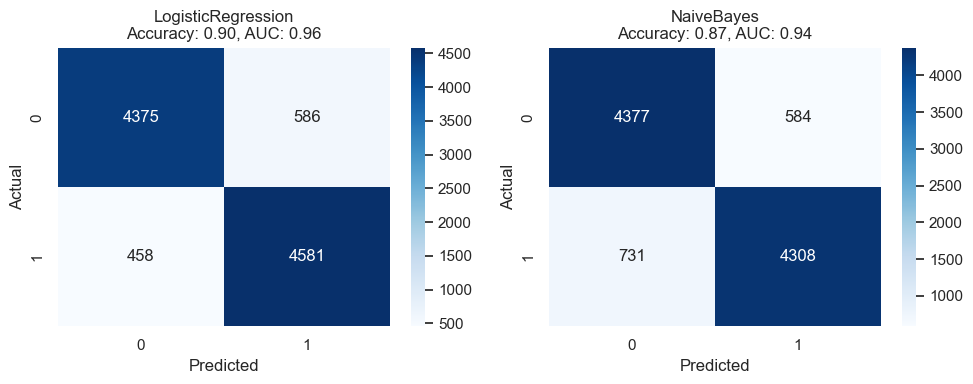

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for ax, (name, res) in zip(axes, results.items()):
    sns.heatmap(res['cm'], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{name}\nAccuracy: {res['acc']:.2f}, AUC: {res['auc']:.2f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

### Summary

In [116]:
for name, res in results.items():
    print(f"{name}: Accuracy={res['acc']:.3f}, ROC AUC={res['auc']:.3f}")


LogisticRegression: Accuracy=0.896, ROC AUC=0.962
NaiveBayes: Accuracy=0.869, ROC AUC=0.940
